In [29]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt

os.chdir("..")
from assistive_arm.utils.data_preprocessing import prepare_mocap_data, prepare_opencap_data, prepare_mocap_force_data, read_headers, export_filtered_force, sync_mocap_with_opencap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

In [30]:
jae_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Masterarbeit Harvard/Thesis/Subject testing/Subject data/jae_data")
project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")

# Set directories
opencap_data = jae_data / "opencap_data"
mocap_data = jae_data / "mocap_data"
opencap_markers = opencap_data / "MarkerData"

In [31]:
# Read force data
mocap_force_right_coordinates = read_headers(mocap_data / "sit_stand0002_f_20.tsv", 25)[9:21]
mocap_force_right = pd.read_csv(
    mocap_data / "sit_stand0002_f_20.tsv", 
    delimiter="\t", 
    skiprows=26, 
    names=["ground_force_r_vx", "ground_force_r_vy", "ground_force_r_vz", "ground_torque_r_x", "ground_torque_r_y", "ground_torque_r_z", "ground_force_r_px", "ground_force_r_py", "ground_force_r_pz", "nan"])
mocap_force_right = mocap_force_right.reindex(columns=["ground_force_r_vx", "ground_force_r_vy", "ground_force_r_vz", "ground_force_r_px", "ground_force_r_py", "ground_force_r_pz", "ground_torque_r_x", "ground_torque_r_y", "ground_torque_r_z", "nan"])

mocap_force_left_coordinates = read_headers(mocap_data / "sit_stand0002_f_21.tsv", 25)[9:21]
mocap_force_left = pd.read_csv(
    mocap_data / "sit_stand0002_f_21.tsv", 
    delimiter="\t",
    skiprows=26, 
    names=["ground_force_l_vx", "ground_force_l_vy", "ground_force_l_vz", "ground_torque_l_x", "ground_torque_l_y", "ground_torque_l_z", "ground_force_l_px", "ground_force_l_py", "ground_force_l_pz", "nan"])
mocap_force_left = mocap_force_left.reindex(columns=["ground_force_l_vx", "ground_force_l_vy", "ground_force_l_vz", "ground_force_l_px", "ground_force_l_py", "ground_force_l_pz", "ground_torque_l_x", "ground_torque_l_y", "ground_torque_l_z", "nan"])

# Read mocap marker data
mocap_marker_names = read_headers(mocap_data / "sit_stand0002.tsv", 10)[-1][-2:] # Read row 10 and get marker names
mocap_markers = pd.read_csv(mocap_data / "sit_stand0002.tsv", delimiter="\t", skiprows=11)

# Read opencap marker data
headers = read_headers(opencap_markers / "sit_stand_2.trc", 3)  
opencap_markers = pd.read_csv(opencap_markers / "sit_stand_2.trc", delimiter="\t", skiprows=3).tail(-1)

## Process data

In [32]:
# Prepare mocap data
mocap_markers = prepare_mocap_data(mocap_markers, mocap_marker_names)
opencap_markers = prepare_opencap_data(opencap_markers)
mocap_forces_in_opencap_frame = prepare_mocap_force_data(mocap_force_right, mocap_force_left, forces_in_world=True)

In [33]:
mocap_markers, mocap_forces_in_opencap_frame, opencap_markers = sync_mocap_with_opencap(marker_data=mocap_markers, force_data=mocap_forces_in_opencap_frame, opencap_data=opencap_markers)

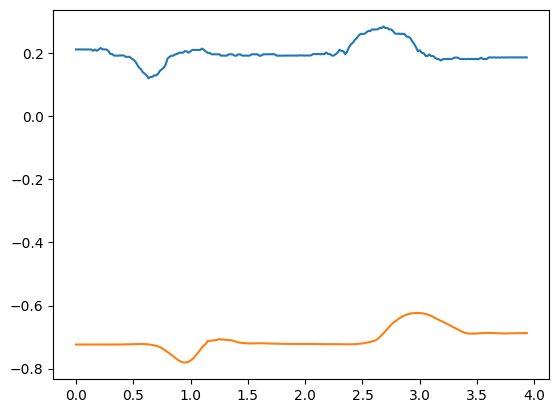

In [34]:
plt.plot(opencap_markers.Time, opencap_markers.LKnee.X)
plt.plot(mocap_markers.Time, mocap_markers.Knee.X)

In [35]:
def transform_force_coordinates(force_trial: pd.DataFrame, new_origin: pd.Series):
    # OpenCap origin in Mocap coordinates, rotated 90 degrees around the x-axis
    T_W_OC = np.array([[1, 0, 0, new_origin.X],
                       [0, 0, -1, new_origin.Y], 
                       [0, 1, 0, 0], # We ignore the Z coordinate because we only care the about the translation on the XY plane
                       [0, 0, 0, 1]])
    
    T_OC_W = np.eye(4)
    T_OC_W[:3, :3] = T_W_OC[:3, :3].T
    T_OC_W[:3, 3] = -T_OC_W[:3, :3] @ T_W_OC[:3, 3]

    # Convert force plate coordinates to MoCap coordinates
    for side in ["r", "l"]:
        cop_cols = [f"ground_force_{side}_px", f"ground_force_{side}_py", f"ground_force_{side}_pz"]
        df_xyz = force_trial.loc[:, cop_cols]
        df_xyz["W"] = 1

        force_cols = [f"ground_force_{side}_vx", f"ground_force_{side}_vy", f"ground_force_{side}_vz"]
        df_vxyz = force_trial.loc[:, force_cols]
        df_vxyz["W"] = 1

        # Transform force vector
        transformed_vxyz = (T_OC_W @ df_vxyz.T).T
        transformed_vxyz.drop(transformed_vxyz.columns[-1], axis=1, inplace=True)
        transformed_vxyz.columns = force_cols
        
        transformed_xyz = (T_OC_W @ df_xyz.T).T
        transformed_xyz.drop(transformed_xyz.columns[-1], axis=1, inplace=True)
        transformed_xyz.columns = cop_cols

        force_trial.loc[:, cop_cols] = transformed_xyz
        force_trial.loc[:, force_cols] = transformed_vxyz

        # Flip y-axis
        force_trial.loc[:, f"ground_force_{side}_vy"] *= -1

    return force_trial

In [36]:
opencap_origin = mocap_markers.Origin.mean(axis=0)
mocap_forces_in_opencap_frame = transform_force_coordinates(force_trial=mocap_forces_in_opencap_frame, new_origin=opencap_origin)

In [37]:
mocap_forces_in_opencap_frame

,time,ground_force_r_vx,ground_force_r_vy,ground_force_r_vz,ground_force_r_px,ground_force_r_py,ground_force_r_pz,ground_torque_r_x,ground_torque_r_y,ground_torque_r_z,ground_force_l_vx,ground_force_l_vy,ground_force_l_vz,ground_force_l_px,ground_force_l_py,ground_force_l_pz,ground_torque_l_x,ground_torque_l_y,ground_torque_l_z
0,0.000000,5.859293,57.081048,-1.074285,0.210330,0.0,0.098871,-6.868485,-0.123876,-1.958325,4.100397,66.834502,-5.497018,0.188047,0.0,-0.258317,8.344792,-1.188810,0.462735
1,0.001667,6.470527,56.471600,-1.079208,0.205851,0.0,0.087881,-7.415298,-0.373412,-1.866335,4.099521,65.003448,-5.498527,0.185664,0.0,-0.254778,8.346030,-1.310672,0.706977
2,0.003333,6.171024,54.640567,-0.768332,0.210136,0.0,0.086764,-7.235089,-0.126969,-2.232441,5.011897,65.613623,-5.813342,0.184011,0.0,-0.250356,8.713690,-1.428871,0.463109
3,0.005000,5.553028,55.859427,-1.374661,0.210167,0.0,0.083140,-7.600326,-0.131457,-1.591032,5.011313,64.392920,-5.814348,0.187480,0.0,-0.239349,9.260204,-1.178548,0.585235
4,0.006667,5.860012,54.639178,-1.375728,0.214591,0.0,0.083405,-7.419569,0.114428,-1.590927,4.700257,66.224623,-6.419766,0.189727,0.0,-0.254377,8.526473,-1.064614,0.584790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2365,3.941667,0.465217,358.020676,23.845572,0.189879,0.0,0.083536,-48.543054,-8.212592,-3.007073,-0.339756,331.754785,-31.780084,0.193649,0.0,-0.252817,43.169779,-4.098251,0.603862
2366,3.943333,1.685670,356.190960,23.531495,0.187684,0.0,0.081832,-48.902363,-8.948352,-3.099210,-0.963326,332.366434,-32.993434,0.193305,0.0,-0.253592,42.988039,-4.222346,0.603877
2367,3.945000,1.068970,360.462510,23.530840,0.188675,0.0,0.084472,-48.539193,-8.700014,-3.557138,-1.877629,334.808269,-32.981262,0.194518,0.0,-0.252909,43.533316,-3.850161,0.481761
2368,3.946667,1.990113,358.633281,23.830011,0.188879,0.0,0.083267,-48.723050,-8.580123,-3.282023,-1.261709,332.366072,-32.379733,0.194042,0.0,-0.253606,42.985388,-3.978321,0.481604


In [38]:
export_filtered_force(mocap_forces_in_opencap_frame, project_moco_data / "forces" / "sit_stand0002_filtered.mot")

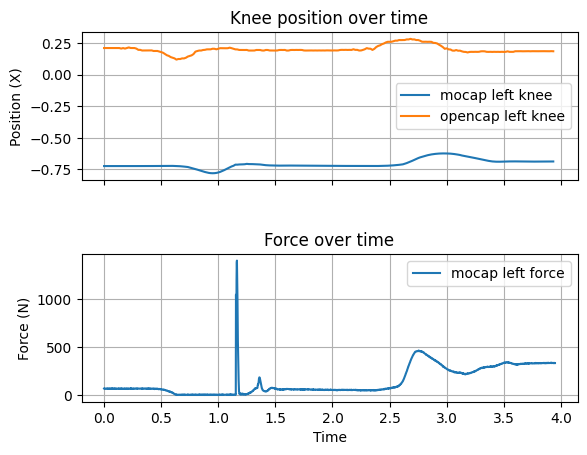

In [39]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.5)

# Top subplot with the mocap left knee and opencap left knee
axs[0].plot(mocap_markers.Time.time, mocap_markers.Knee.X, label="mocap left knee")
axs[0].plot(opencap_markers.Time.t, opencap_markers["LKnee"].X, label="opencap left knee")
axs[0].set_title('Knee position over time')
axs[0].set_ylabel('Position (X)')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot with the mocap left force
axs[1].plot(mocap_forces_in_opencap_frame.time, mocap_forces_in_opencap_frame.ground_force_l_vy, label="mocap left force")
axs[1].set_title('Force over time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Force (N)')
axs[1].legend()
axs[1].grid(True)

plt.show()

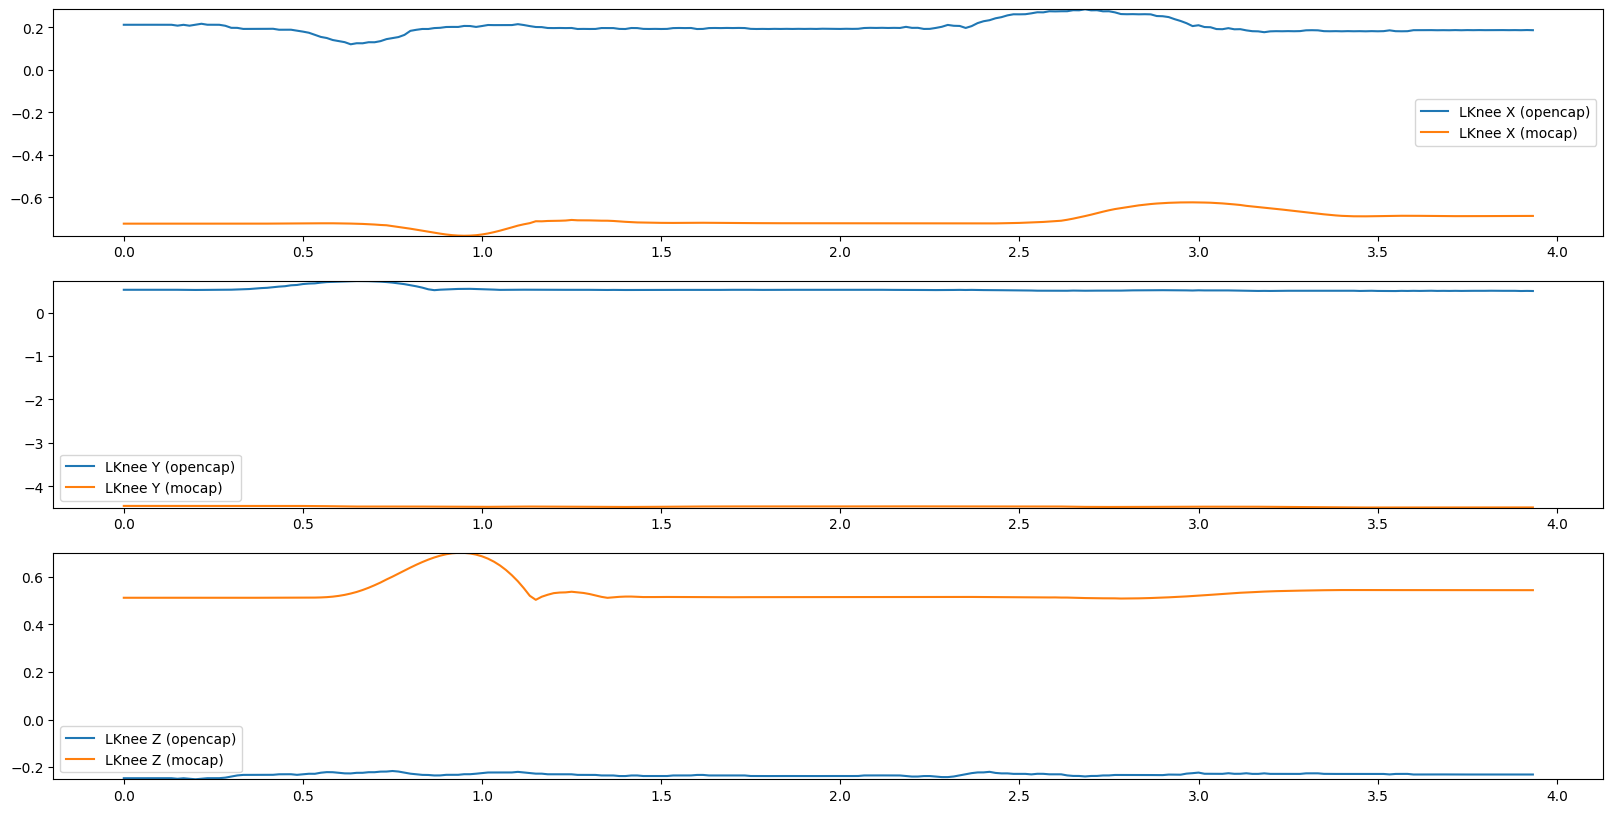

In [40]:
fig, axs = plt.subplots(3, sharex="row", figsize=(20, 10))

# Plot X data
axs[0].plot(opencap_markers["Time"].t, opencap_markers["LKnee"].X, label="LKnee X (opencap)")
axs[0].plot(mocap_markers.Time.time, mocap_markers.Knee.X, label="LKnee X (mocap)")
#axs[0].plot(mocap_force_trial_1_right.time, mocap_force_trial_1_right.FPx, label="LKnee X (mocap force)")
axs[0].legend()

# Plot Y data
axs[1].plot(opencap_markers["Time"].t, opencap_markers["LKnee"].Y, label="LKnee Y (opencap)")
axs[1].plot(mocap_markers.Time.time, mocap_markers.Knee.Y, label="LKnee Y (mocap)")
#axs[1].plot(mocap_force_trial_1_right.timestamp, mocap_force_trial_1_right.FPy, label="LKnee Y (mocap force)")
axs[1].legend()

# Plot Z data
axs[2].plot(opencap_markers["Time"].t, opencap_markers["LKnee"].Z, label="LKnee Z (opencap)")
axs[2].plot(mocap_markers.Time.time, mocap_markers.Knee.Z, label="LKnee Z (mocap)")
#axs[2].plot(mocap_force_trial_1_right.time, mocap_force_trial_1_right.FPz, label="LKnee Z (mocap force)")
axs[2].legend()

axs[0].autoscale(axis='y', tight=True)
axs[1].autoscale(axis='y', tight=True)
axs[2].autoscale(axis='y', tight=True)

# Display the plot
plt.show()